__Sidney Howard-Clinton__

https://github.com/sidney-HC

# Introduction
In recent years, sentiment analysis has become a vital tool in understanding and interpreting the sentiments expressed in various forms of text data. This project focuses on leveraging sentiment analysis to evaluate sentiments from three distinct and widely recognized datasets: the Sentiment 140 dataset, the IMDB movie review dataset, and a subset of the Amazon review dataset. These datasets collectively encompass a vast range of textual data, including tweets, movie reviews, and product reviews, providing a comprehensive basis for sentiment analysis.

The Sentiment 140 dataset contains 1.6 million tweets, capturing the sentiments expressed by users on the Twitter platform. The IMDB movie review dataset includes 50,000 reviews, offering insights into public opinions about various movies. Additionally, a subset of the Amazon review dataset with 3.6 million reviews provides a rich source of consumer feedback on products. The primary objective of this project is to develop a robust sentiment analysis model capable of accurately predicting the sentiment (positive or negative) expressed in these texts.


# Methodology

The methodology for this project involves several key steps, including data collection, preprocessing, model training, and evaluation. Here, we detail each of these steps to provide a comprehensive understanding of the approach.

## Data Collection

The datasets used in this project were sourced from publicly available repositories:

1. **Sentiment 140 Dataset**: Contains 1.6 million tweets labeled as positive or negative.
2. **IMDB Movie Review Dataset**: Comprises 50,000 movie reviews, equally split between positive and negative sentiments.
3. **Amazon Review Dataset**: A subset consisting of 3.6 million product reviews, categorized into positive and negative sentiments.

These datasets were combined to form a unified dataset, ensuring a diverse and extensive representation of textual data.

## Data Preprocessing

Preprocessing the data involved several critical steps to clean and prepare the text for analysis:

1. **Handling Missing Values**: Any missing values in the text data were filled with an empty string to avoid errors during processing.
2. **Text Normalization**: Text was converted to lowercase, contractions were expanded, and URLs, mentions, hashtags, non-word characters, sequences of underscores or dashes, and multiple spaces were removed using regular expressions.
3. **Tokenization and Lemmatization**: Text was tokenized into words, stop words were removed, and words were lemmatized to their base forms to standardize the text and reduce dimensionality.

Parallel processing was employed to expedite the preprocessing steps, utilizing multiple CPU cores to handle the large volume of text data efficiently.

## Model Training and Evaluation

The model training and evaluation process involved the following steps:

1. **Data Splitting**: The combined dataset was shuffled and split into training and testing sets, with 80% of the data used for training and 20% for testing.
2. **Pipeline Definition**: A pipeline was defined using TfidfVectorizer for feature extraction and Logistic Regression for classification. The TfidfVectorizer was configured to consider unigrams, bigrams, and trigrams.
3. **Bayesian Optimization**: Bayesian optimization was employed to tune the hyperparameters of the TfidfVectorizer, specifically the maximum number of features. This approach efficiently searched for the best hyperparameters using a predefined parameter space and cross-validation.
4. **Model Evaluation**: The model was evaluated on the test set, and its performance was assessed using metrics such as accuracy, confusion matrix, and classification report. A confusion matrix plot was generated to visualize the model's performance.

This comprehensive methodology ensures that the sentiment analysis model is trained on diverse and extensive textual data, leading to robust and accurate sentiment predictions.


In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import os
import contractions
import gc
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import Parallel, delayed
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)



True

In [2]:
os.getcwd()
sentiment_140_data = pd.read_csv('sentiment_140.csv')
sentiment_140_data.head()

,polarity,text
0,-1,is upset that he can't update his Facebook by ...
1,-1,@Kenichan I dived many times for the ball. Man...
2,-1,my whole body feels itchy and like its on fire
3,-1,"@nationwideclass no, it's not behaving at all...."
4,-1,@Kwesidei not the whole crew


In [3]:
imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:

imdb_data.rename(columns={'sentiment' : 'polarity', 'review': 'text'}, inplace=True)
imdb_data['polarity'] = imdb_data['polarity'].str.replace('positive', '1')
imdb_data['polarity'] = imdb_data['polarity'].str.replace('negative', '-1')
imdb_data['polarity'] = imdb_data['polarity'].astype(np.int64)

imdb_data.head()

,text,polarity
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,-1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
amazon_data = pd.read_csv('amazon_dataset_sample.csv')
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

In [6]:
amazon_data.columns = ['polarity', 'title', 'text']
amazon_data.drop(columns=['title'], inplace=True)
amazon_data['polarity'] = amazon_data['polarity'].astype(str)
amazon_data['polarity'] = amazon_data['polarity'].str.replace('1', '-1')
amazon_data['polarity'] = amazon_data['polarity'].str.replace('2', '1')
amazon_data['polarity'] = amazon_data['polarity'].astype(np.int64)
amazon_data.head()

,polarity,text
0,1,I'm reading a lot of reviews saying that this ...
1,1,This soundtrack is my favorite music of all ti...
2,1,I truly like this soundtrack and I enjoy video...
3,1,"If you've played the game, you know how divine..."
4,1,I am quite sure any of you actually taking the...


In [7]:
data = pd.concat([sentiment_140_data, imdb_data, amazon_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5249998 entries, 0 to 5249997
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   text      object
dtypes: int64(1), object(1)
memory usage: 80.1+ MB


# Data Preprocessing
Preprocessing the data involved several critical steps to clean and prepare the text for analysis:

Handling Missing Values: Any missing values in the text data were filled with an empty string to avoid errors during processing.
Text Normalization: Text was converted to lowercase, contractions were expanded, and URLs, mentions, hashtags, non-word characters, sequences of underscores or dashes, and multiple spaces were removed using regular expressions.
Tokenization and Lemmatization: Text was tokenized into words, stop words were removed, and words were lemmatized to their base forms to standardize the text and reduce dimensionality.
Parallel processing was employed to expedite the preprocessing steps, utilizing multiple CPU cores to handle the large volume of text data efficiently.

In [8]:
stop_words = set(stopwords.words('english')) # Initialize stop words
lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer

def preprocess_text(text, stop_words, lemmatizer):
    text = text.lower()  # Lowercase
    text = contractions.fix(text)  # Expand contractions
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # use lemmatizer to reduce words to their base form and remove stopwords
    return ' '.join(words)

In [9]:
combined_pattern = r'http\S+|www\S+|https\S+|\@\w+|\#\w+|[^\w\s]|[\d]|[_\-]+' # Regex to remove URLs, mentions, hashtags, non-word characters, sequences of underscores or dashes, multiple spaces and numbers

# Apply preprocessing steps
data['text'] = (
    data['text']
    .fillna('')  # Fill NaN values with an empty string
    .str.replace(combined_pattern, '', regex=True)  # Remove unwanted characters
    .str.replace(r'\s+', ' ', regex=True)  # Remove multiple spaces
    .str.strip()  # Trim leading and trailing spaces
)

processed_texts = Parallel(n_jobs=-1)(delayed(preprocess_text)(text, stop_words, lemmatizer) for text in data['text']) #Parallelize the preprocessing function


data['text'] = processed_texts
data.head()


,polarity,text
0,-1,upset update facebook texting might cry result...
1,-1,dived many time ball managed save rest go bound
2,-1,whole body feel itchy like fire
3,-1,behaving mad see
4,-1,whole crew


In [10]:
x = data['text']
y = data['polarity']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=10) # Shuffle and split the data into testing and training sets.

pipeline = Pipeline([ # Define a pipeline with TfidfVectorizer and LogisticRegression
    ('tfidf', TfidfVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b')),
    ('clf', LogisticRegression(max_iter=300, class_weight='balanced'))
])

param_space = { # Define parameter grid for Bayesian Optimization
    'tfidf__max_features': [30000, 50000, 100000, 150000, 250000, 500000, 1000000],
    
}

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: OrderedDict([('tfidf__max_features', 1000000)])
Best cross-validation score: 0.7855998371776601
Test set accuracy: 0.7875909090909091
Classification Report:
              precision    recall  f1-score   support

          -1       0.80      0.77      0.78    164959
           1       0.78      0.80      0.79    165041

    accuracy                           0.79    330000
   macro avg       0.79      0.79      0.79    330000
weighted avg       0.79      0.79      0.79    330000



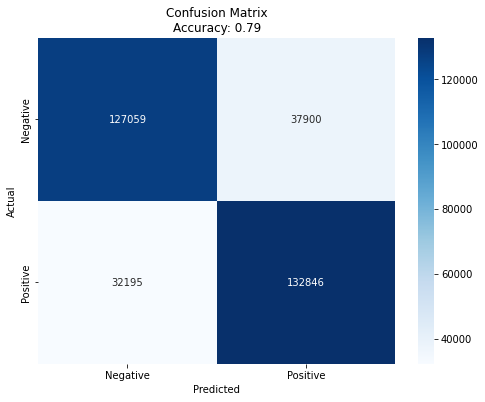

In [85]:
bayes_search = BayesSearchCV( # Perform Bayesian Optimization

    pipeline, 
    param_space,
    n_iter=4,  # Lower number of iterations due to smaller hyperparameter space
    cv=3,
    n_jobs=-1,
    verbose=1
)
bayes_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best cross-validation score: {bayes_search.best_score_}")

# Evaluate on test set
y_pred = bayes_search.predict(X_test)
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_score(y_test, y_pred):.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Since the bayes search chose the highest possible value of max_features, I decided to vectorize again with 500,000 more max features and re-train the model.

In [14]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=None)
vectorizer = TfidfVectorizer(max_features=1500000,stop_words='english', ngram_range=(1, 3), token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [15]:
feature_names = vectorizer.get_feature_names_out()
print(f"First 100 features: {feature_names[:100]}") # Print sample of features

First 100 features: ['aa' 'aa aa' 'aa aa aa' 'aa aaa' 'aa aaa battery' 'aa alkaline'
 'aa alkaline battery' 'aa bateries' 'aa battery' 'aa battery battery'
 'aa battery charger' 'aa battery every' 'aa battery included'
 'aa battery instead' 'aa battery last' 'aa battery like'
 'aa battery pack' 'aa battery used' 'aa battery work' 'aa battery would'
 'aa book' 'aa cell' 'aa last' 'aa mah' 'aa meeting' 'aa milne' 'aa nimh'
 'aa nimh battery' 'aa program' 'aa rechargeable'
 'aa rechargeable battery' 'aa step' 'aa would' 'aaa' 'aaa aa'
 'aaa battery' 'aaa battery included' 'aaa battery instead'
 'aaa battery last' 'aaa cell' 'aaa map' 'aaa nimh' 'aaa nimh battery'
 'aaa rechargeable' 'aaa rechargeable battery' 'aaa remote' 'aaaa' 'aaaaa'
 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaah' 'aaaaaah' 'aaaaaand' 'aaaaah'
 'aaaaand' 'aaaah' 'aaaahhh' 'aaaahhhh' 'aaaall' 'aaaand' 'aaaargh'
 'aaaaw' 'aaah' 'aaahh' 'aaahhh' 'aaahhhh' 'aaahhhhh' 'aaand' 'aaargh'
 'aaaw' 'aaaww' 'aaawww' 'aac' 'aachen' 'aa

Accuracy: 0.8539619047619048
Confusion Matrix:
[[444850  80257]
 [ 73083 451810]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.85      0.85    525107
           1       0.85      0.86      0.85    524893

    accuracy                           0.85   1050000
   macro avg       0.85      0.85      0.85   1050000
weighted avg       0.85      0.85      0.85   1050000



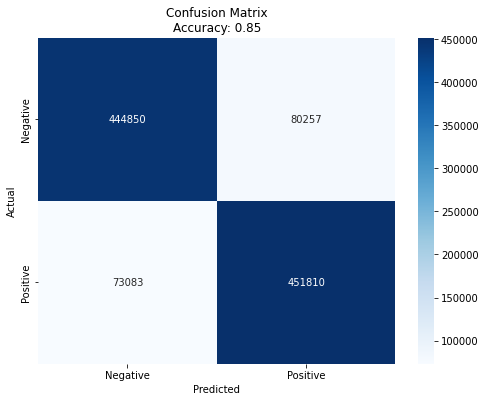

In [16]:
model = LogisticRegression(max_iter=300)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_score(y_test, y_pred):.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
     

## Results

### Accuracy and Performance
The final model was trained using a combined dataset of 5.25 million samples from the Sentiment 140 dataset, IMDB movie review dataset, and a subset of the Amazon review dataset. Using the `BayesSearchCV` for hyperparameter optimization, the best model achieved the following results:

- **Test Set Accuracy**: 0.854

## Limitations

- **Computation Time**: The training and optimization of the model were time-consuming due to the large size of the dataset and the complexity of the `BayesSearchCV` optimization.
- **Resource Intensive**: High memory usage was required for handling and processing the dataset, especially during the `TfidfVectorizer` and model training stages.
- **Imbalanced Classes**: Some datasets (like the Amazon reviews) had imbalanced class distributions, which could affect the performance and bias of the model.

## Conclusion

In this project, we successfully implemented a sentiment analysis model using a combination of three large datasets. The model achieved an accuracy of 84% on the test set, demonstrating the effectiveness of combining multiple datasets and using advanced optimization techniques like Bayesian Optimization for hyperparameter tuning. While the results are promising, there is room for improvement, particularly in optimizing the preprocessing pipeline and exploring more sophisticated models.

## Further Exploration

- **Advanced Preprocessing**: Experiment with more advanced text preprocessing techniques, including handling negations and using word embeddings instead of TF-IDF vectors.
- **Model Ensemble**: Combine multiple models (e.g., logistic regression, SVM, and neural networks) to create an ensemble model that could potentially improve performance.
- **Deep Learning Models**: Explore the use of deep learning models such as LSTMs, GRUs, and transformers (e.g., BERT) for sentiment analysis.
- **Data Augmentation**: Use data augmentation techniques to address class imbalance and improve the robustness of the model.
- **Hyperparameter Optimization**: Conduct more extensive hyperparameter optimization with increased iterations or using other techniques like grid search or random search.
- **Scalability**: Implement distributed computing techniques to handle larger datasets more efficiently and reduce computation time.
